# 2D discrete convolution

This notebook illustrates the 2D (discrete) linear and circular convolutions.

* Jain, A. K. (1989), Fundamentals of Digital Image Processing, Prentice Hall, ISBN 978-0-13-336165-0.

* Horn, R. A. and C. R. Johnson, (1991), Topics in Matrix Analysis, Cambridge University Press, ISBN 978-0-521-46713-1.

* Notes at directory `Content/conv_1D2D/`

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.linalg import toeplitz, circulant, dft
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import my_functions as mfun

## Topics

* [2D circular convolution](#sec1)

    * [Matrix-vector approach](#sec1a)
    
    * [Fourier approach](#sec1b)

* [2D linear convolution](#sec2)

    * [Matrix-vector approach](#sec2a)
    
    * [Fourier approach](#sec2b)

<a id='sec1'></a>
## 2D circular convolution

<a id='sec1a'></a>
### Matrix-vector approach

Let $\mathbf{A}$ and $\mathbf{B}$ be two $M \times N$ matrices. The *2D circular convolution* of $\mathbf{A}$ and $\mathbf{B}$ generates an $M \times N$ matrix $\mathbf{W}$. It can be shown that (see the notes at `Content/conv_1D2D/`) the 2D circular convolution leads to the following matrix-vector product (see the notebook `Block_Toeplitz_circulant_matrices`):

<a id='eq1'></a>
$$
\mathbf{w} = \mathbf{C}_{BCCB} \, \mathbf{a} \tag{1}
$$

where $\mathbf{C}_{BCCB}$ is a BCCB matrix formed by $Q \times Q$ blocks, where each block is a $P \times P$ matrix, $Q = N$, $P = M$, 

<a id='eq2'></a>
$$
\mathbf{w} = 
\begin{bmatrix}
\mathbf{w}_{0} \\
\vdots \\
\mathbf{w}_{Q-1} \\
\end{bmatrix}_{\, QP \times 1} \quad , \tag{2}
$$

<a id='eq3'></a>
$$
\mathbf{a} = 
\begin{bmatrix}
\mathbf{a}_{0} \\
\vdots \\
\mathbf{a}_{Q-1}
\end{bmatrix}_{\, QP \times 1} \quad , \tag{3}
$$

$\mathbf{w}_{k}$ is the $k$th column of $\mathbf{W}$, $k = 0, \dots, Q-1$, $\mathbf{a}_{n}$ is the $n$th column of $\mathbf{A}$, $n = 0, \dots, Q-1$.

The following cells illustrate the particular case in which $M = 5$ and $N = 4$ (page 13 the notes at `Content/conv_1D2D/`).

In [2]:
M = 5
N = 4

A = 20*np.random.rand(M, N)

B = np.arange(M*N).reshape((M, N))

In [3]:
print(A)

[[ 8.98024609  8.01904322 13.31795884  7.46872156]
 [ 2.40577691 14.3698688  10.28206107 13.58160703]
 [ 9.3604616   3.56135951 12.54441967 10.27222038]
 [ 4.26387402 12.5129657   2.58241473  0.99244138]
 [ 1.10735596 19.07922243  5.15310455 18.02754416]]


In [4]:
print(B)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]


In [5]:
Q = N # number of blocks along rows/columns
P = M # number of rows/columns in each block

In [6]:
# define the first column of the Q blocks 
# located along the first block column

columns = B.T

In [7]:
print(columns.shape, Q, P)

(4, 5) 4 5


In [8]:
# create a list of blocks 
list_of_blocks = []
for block_column in columns:
    list_of_blocks.append(circulant(block_column))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [9]:
# create the BCCB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, 0:-Q:-1]
indices = ind_col + ind_row
C_BCCB = np.hstack(np.hstack(list_of_blocks[indices]))

In [10]:
print(C_BCCB.shape, Q, P)

(20, 20) 4 5


In [11]:
# vector a containing the stacked columns of matrix A
a = np.ravel(A.T)

In [12]:
print(a.shape, Q, P)

(20,) 4 5


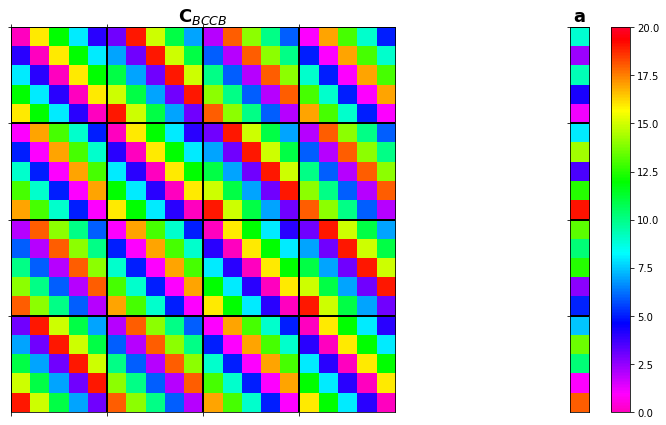

In [13]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{C}_{BCCB}$', fontsize=18)
plt.matshow(C_BCCB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{a}$', fontsize=18)
plt.matshow(np.reshape(a, (a.size,1)), fignum=0, 
            vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [14]:
# partitioned vector containing the the stacked columns of matrix A
w_C_BCCB_a = np.dot(C_BCCB, a)

In [15]:
print(w_C_BCCB_a.shape, Q, P)

(20,) 4 5


In [16]:
# reorganize the elements of w_C_BCCB_a along the columns of a matrix W_C_BCCB_a
W_C_BCCB_a = np.reshape(w_C_BCCB_a, (Q, P)).T
print(W_C_BCCB_a.shape, Q, P)

(5, 4) 4 5


We have just computed the circular convolution of $\mathbf{A}$ and $\mathbf{B}$. What about the circular convolution of $\mathbf{B}$ and $\mathbf{A}$?

<a id='sec1b'></a>
### Fourier approach

The 2D circular convolution ([equation 1](#eq1)) can also be computed by using a Fourier approach (see equations 4b and 9c of the notebook `Block_Toeplitz_circulant_matrices`):

<a id='eq4'></a>
$$
\mathbf{F}_{(P)}^{\ast} \left[ \mathbf{L} \circ \left( \mathbf{F}_{(P)} \mathbf{A} \, \mathbf{F}_{(Q)} \right) \right] \mathbf{F}_{(Q)}^{\ast} = \mathbf{W} \: , \tag{4}
$$

where

<a id='eq5'></a>
$$
\mathbf{L} = \sqrt{QP} \; \mathbf{F}_{(P)} \, \mathbf{B} \, \mathbf{F}_{(Q)} \: . \tag{5}
$$

In [17]:
# matrix L
L = np.sqrt(Q*P)*fft2(x=B, norm='ortho')

In [18]:
# compute a dummy matrix H
H = L*fft2(x=A, norm='ortho')

In [19]:
# matrix W (represented by W_cir_conv_fft)
W_cir_conv_fft = ifft2(x=H, norm='ortho')

In [20]:
# compare the result with that obtained via matrix-vector
np.allclose(W_cir_conv_fft, W_C_BCCB_a)

True

<a id='sec2'></a>
## 2D linear convolution

<a id='sec2a'></a>
### Matrix-vector approach

Let $\mathbf{A}$ be an $M_{a} \times N_{a}$ matrix and $\mathbf{B}$ be an $M_{b} \times N_{b}$ matrix. The *2D linear convolution* of $\mathbf{A}$ and $\mathbf{B}$ generates a $M_{w} \times N_{w}$ matrix $\mathbf{W}$, where $M_{w} = M_{a} + M_{b} - 1$ and $N_{w} = N_{a} + N_{b} - 1$. It can be shown that (see the notes at `Content/conv_1D2D/`) the 2D linear convolution leads to the following matrix-vector product (see the notebook `Block_Toeplitz_circulant_matrices`):

<a id='eq6'></a>
$$
\mathbf{w}_{padd} = \mathbf{B}_{BTTB} \, \mathbf{a}_{padd} \tag{6}
$$

where $\mathbf{B}_{BTTB}$ is a BTTB matrix formed by $Q \times Q$ blocks, where each block is a $P \times P$ matrix, $Q = N_{a} + N_{b}$, $P = M_{a} + M_{b}$, 

<a id='eq7'></a>
$$
\mathbf{w}_{padd} = 
\begin{bmatrix}
\left( \begin{array}{c} \mathbf{w}_{0} \\ 0 \end{array} \right) \\
\vdots \\
\left( \begin{array}{c} \mathbf{w}_{Q-2} \\ 0 \end{array} \right) \\
\mathbf{0}_{P}
\end{bmatrix}_{\, QP \times 1} \quad , \tag{7}
$$

<a id='eq8'></a>
$$
\mathbf{a}_{padd} = 
\begin{bmatrix}
\left( \begin{array}{c} \mathbf{a}_{0} \\ \mathbf{0}_{Mb} \end{array} \right) \\
\vdots \\
\left( \begin{array}{c} \mathbf{a}_{Na-1} \\ \mathbf{0}_{Mb} \end{array} \right) \\
\mathbf{0}_{Nb \, P}
\end{bmatrix}_{\, QP \times 1} \quad , \tag{8}
$$

$\mathbf{w}_{k}$ is the $k$th column of $\mathbf{W}$, $k = 0, \dots, N_{w}-1$, $\mathbf{a}_{n}$ is the $n$th column of $\mathbf{A}$, $n = 0, \dots, N_{a}-1$, and $\mathbf{0}_{\alpha}$ are $\alpha \times 1$ vectors with all elements equal to zero.

The following cells illustrate the particular case in which $M_{a} = 6$, $N_{a} = 4$, $M_{b} = 5$ and $N_{b} = 3$ (pages 11 and 12 of the notes at `Content/conv_1D2D/`).

In [ ]:
# define matrix A
Ma = 6
Na = 4

A = 16*np.random.rand(Ma, Na) + 4

# define matrix B
Mb = 5
Nb = 3

B = np.arange(4, Mb*Nb+4).reshape((Mb, Nb))

In [ ]:
print(A)

In [ ]:
print(B)

In [ ]:
Q = Na + Nb # number of blocks along rows/columns
P = Ma + Mb # number of rows/columns in each block

In [ ]:
# define the first column and first row of the 2*Q - 1 blocks 
# located along the first block row and column

# first columns of blocks along the first block row
columns = []
for n in range(Q-1):
    columns.append(np.zeros(P))

# first columns of the non-null blocks along the first block column
for n in range(Nb):
    columns.append(np.hstack([B[:,n], np.zeros(Ma)]))

# first columns of last blocks along the first block column
for n in range(Na):
    columns.append(np.zeros(P))

columns = np.vstack(columns)

# first rows of all blocks along the first block row and column
rows = np.zeros((2*Q - 1, P))

In [ ]:
print(columns.shape, Q, P)

In [ ]:
print(rows.shape, Q, P)

In [ ]:
# create a list of blocks 
list_of_blocks = []
for block_column, block_row in zip(columns, rows):
    list_of_blocks.append(toeplitz(block_column, block_row))
list_of_blocks = np.stack(list_of_blocks, axis=0)

In [ ]:
# create the BTTB matrix from the list of blocks
ind_col, ind_row = np.ogrid[0:Q, Q-1:-1:-1]
indices = ind_col + ind_row
B_BTTB = np.hstack(np.hstack(list_of_blocks[indices]))

In [ ]:
print(B_BTTB.shape, Q, P)

In [ ]:
# vector a containing the stacked-padded columns of matrix A
a_padd = []

# non-null subvetors
for n in range(Na):
    a_padd.append(np.hstack([A[:,n], np.zeros(Mb)]))

# null subvectors
for n in range(Nb):
    a_padd.append(np.zeros(P))

a_padd = np.hstack(a_padd)

In [ ]:
print(a_padd.shape, Q, P)

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
plt.title('$\mathbf{B}_{BTTB}$', fontsize=18)
plt.matshow(B_BTTB, fignum=0, vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.subplot(1,2,2)
plt.title('$\mathbf{a}_{padd}$', fontsize=18)
plt.matshow(np.reshape(a_padd, (a_padd.size,1)), fignum=0, 
            vmin = 0, vmax = 20, cmap='gist_rainbow_r')
plt.colorbar()
plt.xticks(ticks=[5], labels=[])
plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
plt.grid(color='k', linewidth=2)

plt.tight_layout()

plt.show()

In [ ]:
# partitioned vector containing the 2D linear convolution
w_B_BTTB_a_padd = np.dot(B_BTTB, a_padd)

In [ ]:
print(w_B_BTTB_a_padd.shape, Q, P)

In [ ]:
# reorganize the elements of w_B_BTTB_a_padd along the columns of a matrix W_B_BTTB_a_padd
W_B_BTTB_a_padd = np.reshape(w_B_BTTB_a_padd, (Q, P)).T
print(W_B_BTTB_a_padd.shape, Q, P)

In [ ]:
# finally, remove the null elements of W_B_BTTB_a_padd
W_B_BTTB_a_padd = W_B_BTTB_a_padd[:P-1, :Q-1]
print(W_B_BTTB_a_padd.shape, Q, P)

In [ ]:
# compute the 2D linear convolution with scipy.signal.convolve2d
W_scipy = convolve2d(in1=A, in2=B, mode='full')

In [ ]:
print(W_scipy.shape, Q, P)

In [ ]:
# compare the results
np.allclose(W_B_BTTB_a_padd, W_scipy)

We have just computed the linear convolution of $\mathbf{A}$ and $\mathbf{B}$. What about the linear convolution of $\mathbf{B}$ and $\mathbf{A}$?

<a id='sec2b'></a>
### Fourier approach

The 2D linear convolution ([equation 6](#eq6)) can also be computed by using a Fourier approach (see the notebook `Block_Toeplitz_circulant_matrices`):

<a id='eq9'></a>
$$
\mathbf{F}_{(P)}^{\ast} \left[ \mathbf{L} \circ \left( \mathbf{F}_{(P)} \mathbf{A}_{padd} \, \mathbf{F}_{(Q)} \right) \right] \mathbf{F}_{(Q)}^{\ast} = \mathbf{W}_{padd} \: , \tag{9}
$$

where $\mathbf{F}_{(Q)}$ and $\mathbf{F}_{(P)}$ are the Fourier matrices of order $Q$ and $P$, respectively, normalized by $\sqrt{Q}$ and $\sqrt{P}$ (see the notebook `fourier_1D_4`), $\mathbf{W}_{padd}$ and $\mathbf{A}_{padd}$ are $P \times Q$ matrices obtained, respectively, by reorganizing the vectors $\mathbf{w}_{padd}$ ([equation 7](#eq7)) and $\mathbf{a}_{padd}$ ([equation 8](#eq8)) along their columns and

<a id='eq10'></a>
$$
\mathbf{L} = \sqrt{QP} \; \mathbf{F}_{(P)} \, \mathbf{B}_{padd} \, \mathbf{F}_{(Q)} \: , \tag{10}
$$

where $\mathbf{B}_{padd}$ is a $P \times Q$ matrix obtained by padding matrix $\mathbf{B}$ with zeros. Notice that, similarly, $\mathbf{A}_{padd}$ is a $P \times Q$ matrix obtained by padding matrix $\mathbf{A}$ with zeros. See equations 4b and 9c of the notebook `Block_Toeplitz_circulant_matrices`.

In [ ]:
# matrix B_padd
B_padd = np.hstack([np.vstack([B, np.zeros((Ma, Nb))]), 
                    np.zeros((P, Na))])

In [ ]:
print(B_padd.shape, Q, P)

In [ ]:
# matrix L
L = np.sqrt(Q*P)*fft2(x=B_padd, norm='ortho')

In [ ]:
# matrix A_padd
A_padd = np.reshape(a_padd, (Q, P)).T

In [ ]:
print(A_padd.shape, Q, P)

In [ ]:
# compute a dummy matrix H
H = L*fft2(x=A_padd, norm='ortho')

In [ ]:
# matrix W_padd (represented by W_lin_conv_fft)
W_lin_conv_fft = ifft2(x=H, norm='ortho')

# matrix W (obtained by removing the zeros from W_lin_conv_fft)
W_lin_conv_fft = W_lin_conv_fft[:P-1, :Q-1]

In [ ]:
# compare the result with that obtained via matrix-vector
np.allclose(W_lin_conv_fft, W_B_BTTB_a_padd)